In [450]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime as dt

import folium
import folium.plugins
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon

In [451]:
incident_report = pd.read_csv('Police_Department_Incident_Reports__2018_to_Present.csv')
reference_codes = pd.read_csv('Reference__Police_Department_Incident_Code_Crosswalk_with_ucr.csv')

# rename reference code column to merge 
reference_codes.rename(columns = {'INC_CODE':'Incident Code'}, inplace = True)

# merge dataframes; 460432 rows and 39 columns
incident_report = incident_report.merge(reference_codes, on = 'Incident Code', how = 'left', indicator = True)
pd.set_option('display.max_columns', None)

In [452]:
# incident_report.info()

In [453]:
incident_report['_merge'].value_counts(dropna = False)

both          460073
left_only        359
right_only         0
Name: _merge, dtype: int64

In [454]:
## 685 codes that do not have corresponding UCR category
reference_codes.loc[reference_codes['UCR_part_1'].isna(), 'Incident Code'].value_counts(dropna = False)

1051     1
27190    1
27172    1
27173    1
27174    1
        ..
15162    1
15163    1
15200    1
15201    1
75030    1
Name: Incident Code, Length: 685, dtype: int64

# Data Wrangling

In [455]:
# dropping columns

incident_report.drop(columns = ['Incident Datetime','Supervisor District', 'Current Supervisor Districts'], inplace = True)

In [456]:
# function to filter out unwanted categories
def filter_rows_by_values(df, col, values):
    return df[df[col].isin(values) == False]

In [457]:
# updated has 246439 rows and 36 columns
incident_report = filter_rows_by_values(incident_report, 'Incident Category', ['Case Closure','Civil Sidewalks','Courtesy Report',
                              'Fire Report','Lost Property','Missing Person','Non-Criminal',
                              'Other','Recovered Vehicle','Suicide','Suspicious','Suspicious Occ',
                              'Traffic Collision','Vehicle Impounded','Vehicle Misplaced','Warrant', 'Liquor Laws', 'Gambling',
                            'Malicious Mischief', 'Other Miscellaneous','Fraud', 'Disorderly Conduct', 'Miscellaneous Investigation',
                                'Other Offenses', 'Traffic Violation Arrest', 'Weapons Offense', 'Forgery and Counterfeiting', 'Weapons Carrying Etc',
                                'Stolen Property', 'Prostitution', 'Embezzlement', 'Vandalism', 'Sex Offense'])

In [458]:
# convert to datetime ; data starts at 2018-01-01 and ends at 2021-07-20

incident_report['Incident Date'] = pd.to_datetime(incident_report['Incident Date'])

In [459]:
# omitting entries later than June 30, 2021 because latest date is 07-20-2021
# 243098 rows and 37 columns

incident_report = incident_report[incident_report['Incident Date'] <= '2021-06-30']

In [460]:
# extracting months variable

incident_report['Months']=incident_report['Incident Date'].dt.month

In [461]:
# changing to month digits to full month names 
months_dict = {1:'January', 2:'February', 3:'March', 4:'April',5:'May', 6:'June', 
           7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}

incident_report['Months'].replace(months_dict, inplace = True)

In [462]:
# dropping duplicates and keeping only the highest crime category based on UCR hierarchy 
# 228879 rows and 37 columns
incident_report = incident_report.sort_values('UCR_part_1_code').drop_duplicates('Incident ID', keep = 'first')

In [463]:
# variable to see whether there is a CAD number or not
# 232017 rows and 38 columns
incident_report['Binary CAD'] = incident_report['CAD Number'].notnull()*1

In [464]:
# adding geometric variable

geometry = [Point(xy) for xy in zip(incident_report['Longitude'], incident_report['Latitude'])]
incident_report = gpd.GeoDataFrame(incident_report, 
                          geometry = geometry)

In [465]:
incident_report['Incident Category'].value_counts(dropna = False)

Larceny Theft                                   136187
Burglary                                         24378
Assault                                          22959
Motor Vehicle Theft                              20113
Robbery                                          10515
Drug Offense                                      6548
Offences Against The Family And Children          4750
Forgery And Counterfeiting                        1502
Arson                                             1167
NaN                                                306
Drug Violation                                     121
Human Trafficking (A), Commercial Sex Acts         107
Rape                                               102
Homicide                                            52
Motor Vehicle Theft?                                45
Weapons Offence                                     14
Human Trafficking, Commercial Sex Acts              12
Human Trafficking (B), Involuntary Servitude         1
Name: Inci

In [466]:
incident_report['UCR_part_1'].value_counts(dropna = False)

larceny theft          130264
NaN                     33851
burglary                24378
motor vehicle theft     20158
robbery                 10515
aggravated assault       8392
arson                    1167
rape                      102
homicide                   52
Name: UCR_part_1, dtype: int64

# Why the NaN values?

In [467]:
incident_report[incident_report['Incident Category'] == 'Larceny Theft'][incident_report['UCR_part_1'] != 'larceny theft']['Incident Code'].head()

C:\Users\simon\anaconda3\envs\geo_env\lib\site-packages\geopandas\geodataframe.py:1299: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


19     71013
74     71013
111    71013
121    71013
217    71013
Name: Incident Code, dtype: int64

In [468]:
incident_report['Resolution'].value_counts(dropna = False)

Open or Active          202030
Cite or Arrest Adult     26195
Unfounded                  341
Exceptional Adult          313
Name: Resolution, dtype: int64

In [469]:
incident_report['Report Type Description'].value_counts()

Initial                117564
Coplogic Initial        64210
Vehicle Initial         23726
Initial Supplement      12313
Coplogic Supplement      9724
Vehicle Supplement       1342
Name: Report Type Description, dtype: int64

In [470]:
## visualizing all on one line 

## line graph by month for each UCR category ** ask about this
## full year before pandemic then over year for post-period (March 2019 to recent)

### create new variables 

### Figure out a code that will do this: 
## UCR hierarchy rule - ex: Incident ID: XXXX; the rows with this iD are homicide, robbery,
## aggravated assault; with the UCR rule, only count homicide as it it the highest offense

In [471]:
### NOTES ###
## incident code
## aggregate by month and compares each year on different lines ; no categories 
## (total crime for total, violent, property, etc)
## do time series analyses **most important part for trends 
## neighborhood variation; maps, aggregating to the neighorbhood level and doing descirptives and seeing what neighborhoods have different patterns than city patterns
## use communities in crime data first

## what variables correlated with missing values 
## to better understand limitations when plotting
## know which crime categories by fraction of missing locations - something interesting

## to what extent covid changed foot traffic
## number of crime for individuals on street 

## neighborhood analysis - violent versus property ; 
## prepan/postpan - aggregate 
## trend line??


In [472]:
incident_report['Police District'].value_counts()

Central       39331
Northern      36834
Mission       27747
Southern      26938
Bayview       18588
Tenderloin    17808
Richmond      16481
Ingleside     16206
Taraval       15740
Park          11069
Out of SF      2137
Name: Police District, dtype: int64

In [473]:
incident_report['Analysis Neighborhood'].value_counts(dropna = False)

Mission                           21231
Financial District/South Beach    20540
Tenderloin                        18154
South of Market                   15531
NaN                               13494
Bayview Hunters Point             11397
North Beach                        8514
Hayes Valley                       7434
Western Addition                   7416
Marina                             7363
Castro/Upper Market                6676
Russian Hill                       6599
Nob Hill                           6497
Sunset/Parkside                    5772
Outer Richmond                     5436
Pacific Heights                    4670
West of Twin Peaks                 4488
Potrero Hill                       4335
Bernal Heights                     3927
Haight Ashbury                     3622
Chinatown                          3578
Excelsior                          3348
Mission Bay                        3234
Inner Sunset                       3020
Inner Richmond                     2932


# Total Incidents

In [474]:
## function to filter wanted categories
def filter_inrows_by_values(df, col, values):
    return df[df[col].isin(values) == True]

In [475]:
## total_incidents1 - with 8 UCR categories - reduces the dataset to 195028 rows
total_incidents1 = filter_inrows_by_values(incident_report, 'UCR_part_1', ['aggravated assault', 'rape',
                                                                        'homicide ', 'robbery', 'burglary ', 
                                                                        'arson', 'larceny theft','motor vehicle theft'])
total_incidents = pd.pivot_table(total_incidents1, index = 'Months', columns = 'Incident Year', values = 'Incident ID', aggfunc = 'size')
total_incidents = total_incidents.reindex(index = ['January', 'February', 'March', 'April', 'May', 
                                 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
total_incidents 

Incident Year,2018,2019,2020,2021
Months,,,,
January,5860.0,4889.0,5522.0,3461.0
February,4831.0,4482.0,4799.0,3690.0
March,5075.0,4811.0,3791.0,3706.0
April,5086.0,4669.0,3214.0,3808.0
May,5379.0,5076.0,3167.0,4834.0
June,5424.0,5159.0,2808.0,4702.0
July,6189.0,5795.0,3122.0,NaN
August,6094.0,6075.0,3047.0,NaN
September,5461.0,5629.0,2588.0,NaN


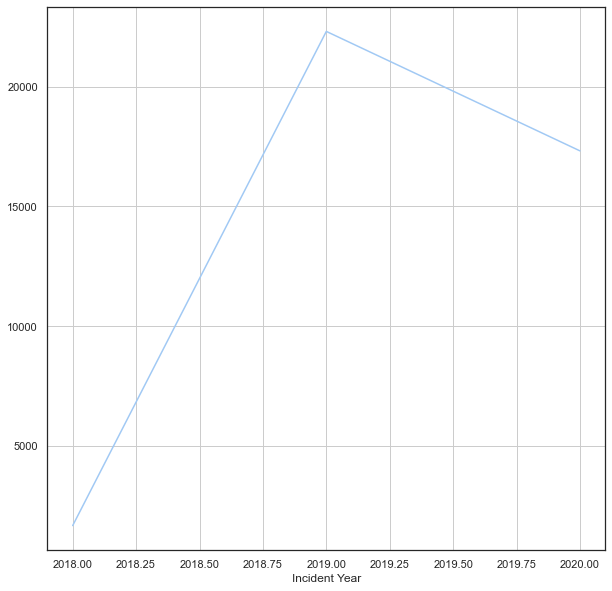

In [476]:
ax1 = total_incidents.sum(axis='rows').diff(periods=-1).plot(grid=True)

<AxesSubplot:xlabel='Incident Year'>

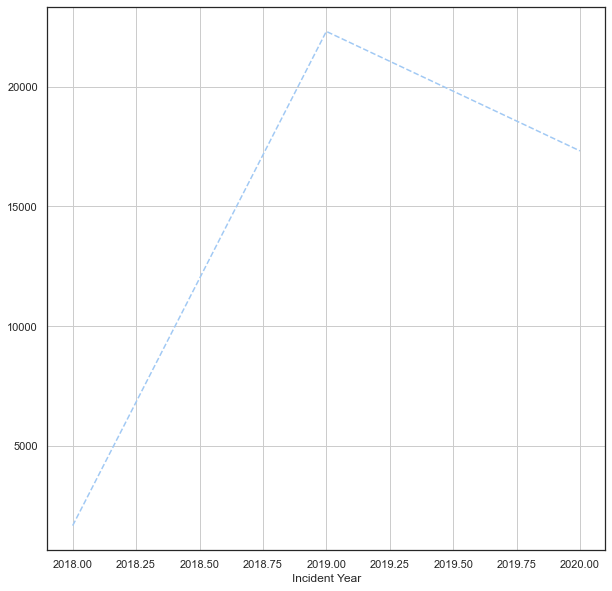

In [477]:
ax = total_incidents.sum(axis='rows').diff(periods = -1).plot(
  grid = True, color='b', style='--', label='Raw'
)
total_incidents.sum(axis='rows').diff(periods=1).rolling(window=7).mean().plot(
  grid = True, color='k', style='-', label='Rolling average', ax=ax
)

In [484]:
total_incidents1.columns

Index(['Incident Date', 'Incident Time', 'Incident Year',
       'Incident Day of Week', 'Report Datetime', 'Row ID', 'Incident ID',
       'Incident Number', 'CAD Number', 'Report Type Code',
       'Report Type Description', 'Filed Online', 'Incident Code',
       'Incident Category', 'Incident Subcategory', 'Incident Description',
       'Resolution', 'Intersection', 'CNN', 'Police District',
       'Analysis Neighborhood', 'Latitude', 'Longitude', 'Point',
       'Neighborhoods', 'ESNCAG - Boundary File',
       'Central Market/Tenderloin Boundary Polygon - Updated',
       'Civic Center Harm Reduction Project Boundary',
       'HSOC Zones as of 2018-06-05', 'Invest In Neighborhoods (IIN) Areas',
       'Current Police Districts', 'CATEGORY', 'SUBCATEGORY', 'UCR_part_1',
       'UCR_part_1_code', '_merge', 'Months', 'Binary CAD', 'geometry'],
      dtype='object')

In [485]:
total_incidents1['Police District'].value_counts(dropna = False)

Central       35783
Northern      33318
Mission       22813
Southern      22665
Bayview       15161
Richmond      15159
Taraval       13424
Ingleside     13172
Tenderloin    11918
Park           9818
Out of SF      1797
Name: Police District, dtype: int64

<AxesSubplot:xlabel='Incident Year'>

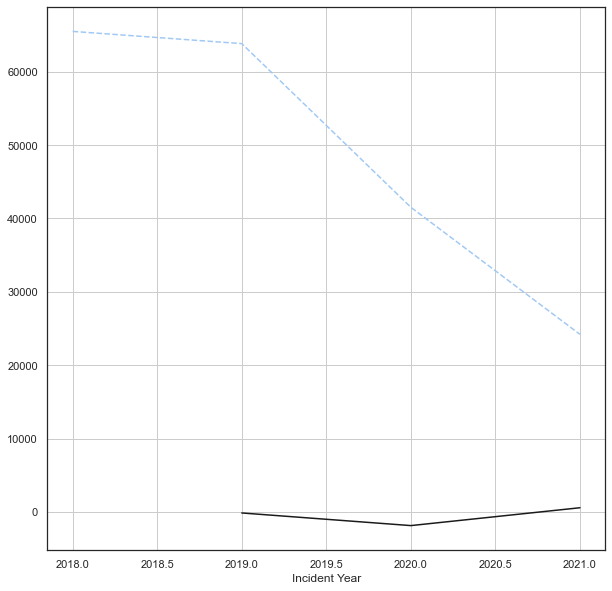

In [403]:
ax = total_incidents.sum(axis='rows').plot(
  grid=True, color='b', style='--', label='Raw'
)
total_incidents.mean(axis='rows').diff(periods=1).plot(
  grid=True, color='k', style='-', label='Rolling average',ax = ax
)

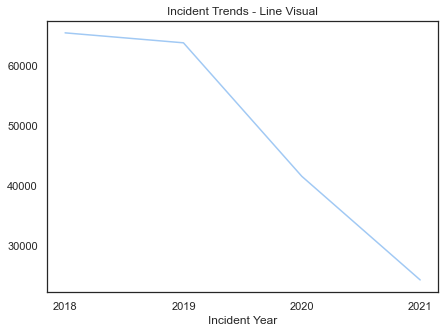

In [404]:
# yearly incident trends sum
single = total_incidents.sum().plot(kind = 'line', figsize = (7,5), rot = 0)
total_incidents.sum(axis = 'rows').diff(periods=1).rolling(window=7).mean().plot(
  color='k', style='-', label='Rolling average',ax = ax
)
single.set_xticks(range(2018,2022))
plt.title('Incident Trends - Line Visual');

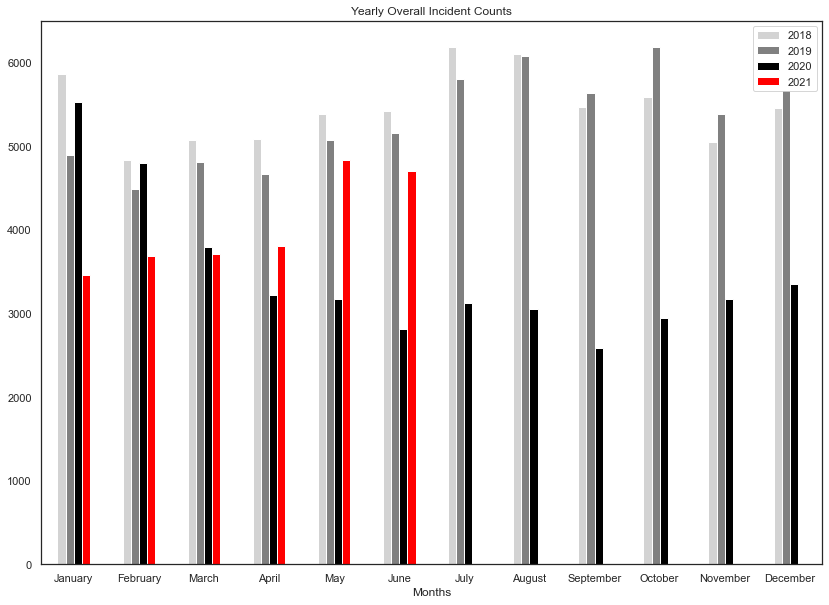

In [405]:
total_incidents.plot(kind = 'bar', figsize = (14,10),color = ['lightgray', 'gray', 'black', 'red'], rot = 0)
plt.title('Yearly Overall Incident Counts')
plt.legend(loc = 'best');

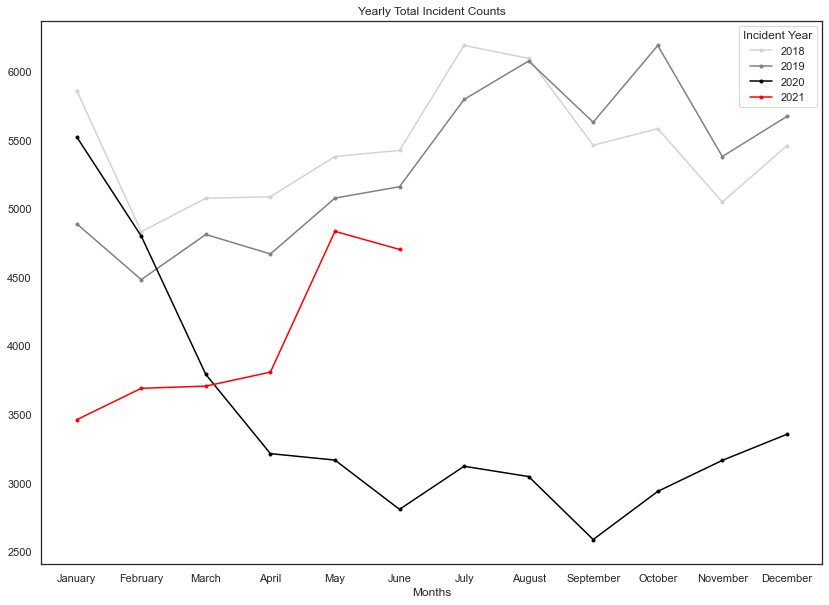

In [406]:
line = total_incidents.plot(kind = 'line', figsize = (14,10),color = ['lightgray', 'gray', 'black', 'red'], 
                            marker = '.',rot = 0)
line.set_xticks(np.arange(0,12))
line.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 
                    'July', 'August', 'September', 'October','November', 'December'])
line.set_title('Yearly Total Incident Counts');

# Violent Incidents 

In [407]:
# violent crime visualization 
# (19061, 39) using UCR categories

violentincidents = filter_inrows_by_values(incident_report, 'UCR_part_1', ['aggravated assault', 'rape',
                                                                           'homicide ', 'robbery'])
violentincidents.head();

In [408]:
violentincidents.shape

(19061, 39)

In [409]:
violentincidents['UCR_part_1'].value_counts()

robbery               10515
aggravated assault     8392
rape                    102
homicide                 52
Name: UCR_part_1, dtype: int64

In [410]:
violent_incidents = pd.pivot_table(violentincidents, index = 'Months', columns = 'Incident Year', values = 'UCR_part_1', aggfunc = 'size')
total_violentincidents = violent_incidents.reindex(index = ['January', 'February', 'March', 'April', 'May', 
                                 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
total_violentincidents

Incident Year,2018,2019,2020,2021
Months,,,,
January,492.0,460.0,461.0,353.0
February,536.0,373.0,518.0,435.0
March,507.0,494.0,444.0,375.0
April,471.0,462.0,319.0,385.0
May,548.0,508.0,305.0,439.0
June,581.0,498.0,274.0,439.0
July,579.0,503.0,298.0,NaN
August,545.0,590.0,287.0,NaN
September,497.0,504.0,302.0,NaN


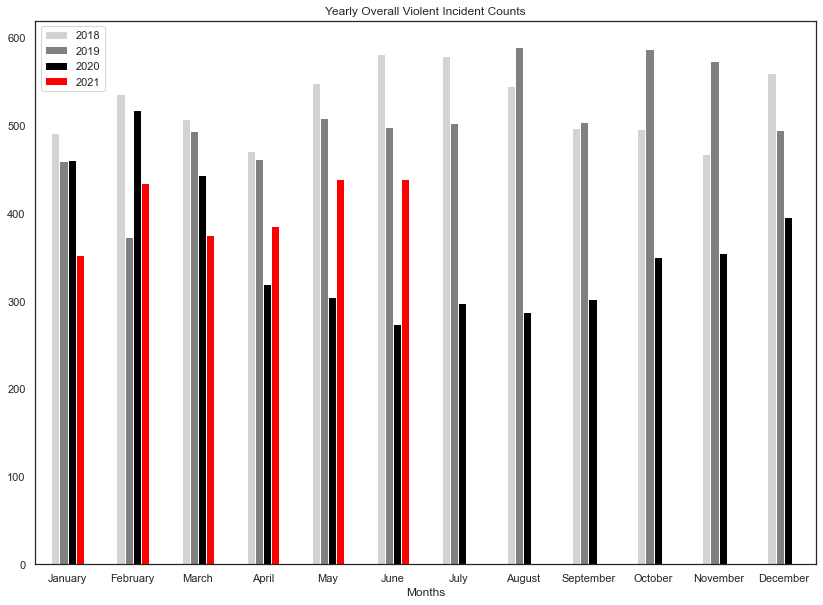

In [411]:
total_violentincidents.plot(kind = 'bar', figsize = (14,10),color = ['lightgray', 'gray', 'black', 'red'], rot = 0)
plt.title('Yearly Overall Violent Incident Counts')
plt.legend(loc = 'best');

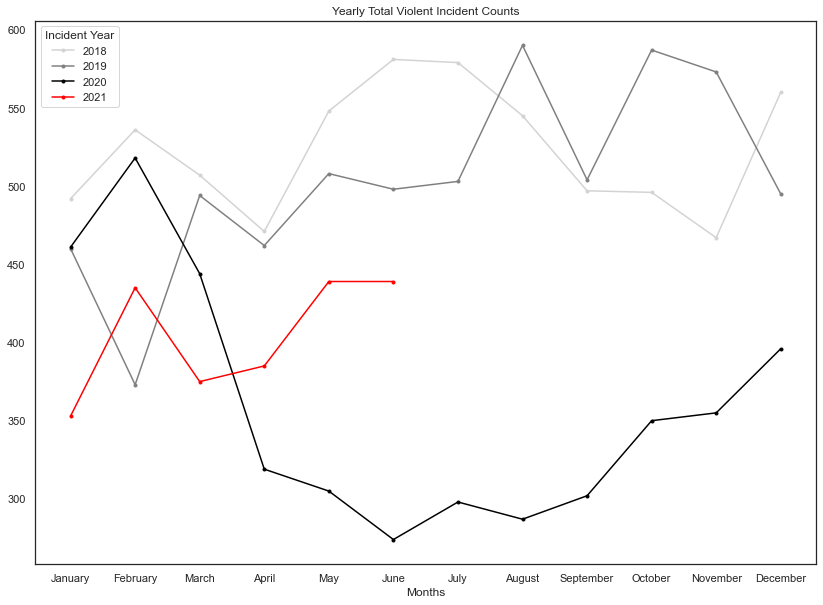

In [412]:
violentline = total_violentincidents.plot(kind = 'line', figsize = (14,10),color = ['lightgray', 'gray', 'black', 'red'], 
                            marker = '.',rot = 0)
violentline.set_xticks(np.arange(0,12))
violentline.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 
                    'July', 'August', 'September', 'October','November', 'December'])
violentline.set_title('Yearly Total Violent Incident Counts');

In [413]:
## when violent incidents occur (month/year)

pd.pivot_table(violentincidents, index = ['UCR_part_1', 'Months'], 
               columns = ['Incident Year'], values = 'Incident Code', aggfunc = 'size')


Incident Year                  2018   2019   2020   2021
UCR_part_1         Months                               
aggravated assault April      228.0  203.0  151.0  207.0
                   August     239.0  270.0  134.0    NaN
                   December   198.0  206.0  179.0    NaN
                   February   222.0  140.0  185.0  175.0
                   January    212.0  164.0  163.0  175.0
                   July       227.0  240.0  139.0    NaN
                   June       256.0  221.0  133.0  226.0
                   March      217.0  240.0  184.0  178.0
                   May        239.0  249.0  164.0  240.0
                   November   193.0  201.0  178.0    NaN
                   October    208.0  228.0  205.0    NaN
                   September  191.0  215.0  169.0    NaN
homicide           April        1.0    1.0    NaN    NaN
                   August       8.0    1.0    NaN    NaN
                   December     5.0    NaN    4.0    NaN
                   February     NaN    NaN    2.0    2.0
                   January      1.0    1.0    NaN    1.0
                   June         1.0    4.0    NaN    NaN
                   March        1.0    1.0    NaN    1.0
                   May          2.0    2.0    1.0    1.0
                   November     2.0    2.0    NaN    NaN
                   October      2.0    3.0    NaN    NaN
                   September    1.0    NaN    1.0    NaN
rape               April        3.0    1.0    NaN    1.0
                   August       7.0    1.0    1.0    NaN
                   December     1.0    5.0    NaN    NaN
                   February     3.0    3.0    2.0    1.0
                   January      2.0    7.0    4.0    1.0
                   July         6.0    4.0    2.0    NaN
                   June         5.0    3.0    2.0    3.0
                   March        2.0    2.0    1.0    3.0
                   May          1.0    3.0    2.0    NaN
                   November     1.0    4.0    2.0    NaN
                   October      4.0    2.0    2.0    NaN
                   September    4.0    1.0    NaN    NaN
robbery            April      239.0  257.0  168.0  177.0
                   August     291.0  318.0  152.0    NaN
                   December   356.0  284.0  213.0    NaN
                   February   311.0  230.0  329.0  257.0
                   January    277.0  288.0  294.0  176.0
                   July       346.0  259.0  157.0    NaN
                   June       319.0  270.0  139.0  210.0
                   March      287.0  251.0  259.0  193.0
                   May        306.0  254.0  138.0  198.0
                   November   271.0  366.0  175.0    NaN
                   October    282.0  354.0  143.0    NaN
                   September  301.0  288.0  132.0    NaN

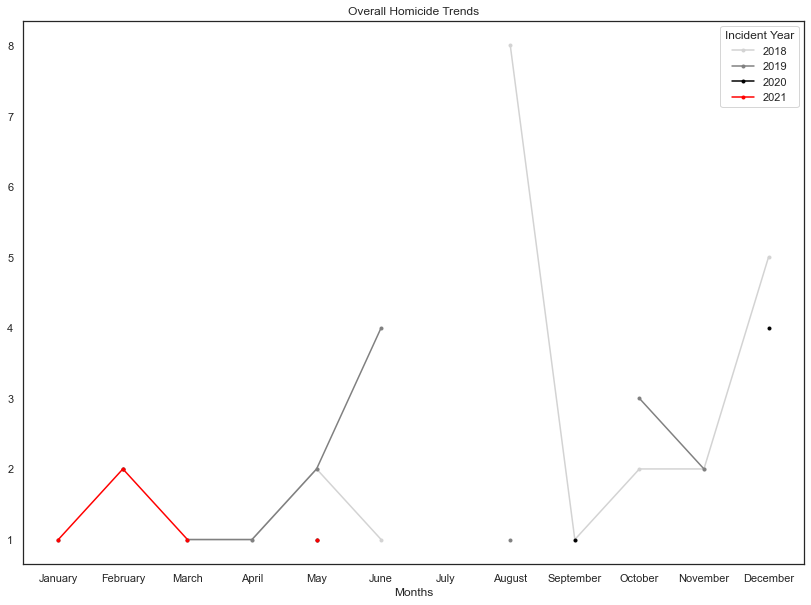

In [414]:
homicide = violentincidents[violentincidents['UCR_part_1'] == 'homicide ']
homicide2 = pd.pivot_table(homicide, index = 'Months', columns = 'Incident Year', values = 'Incident ID', aggfunc = 'size')
homicide2 = homicide2.reindex(index = ['January', 'February', 'March', 'April', 'May', 
                                 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
homicidepl = homicide2.plot(kind = 'line', figsize = (14,10),color = ['lightgray', 'gray', 'black', 'red'], 
                            marker = '.',rot = 0)

homicidepl.set_xticks(np.arange(0,12))
homicidepl.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 
                    'July', 'August', 'September', 'October','November', 'December'])
homicidepl.set_title('Overall Homicide Trends');

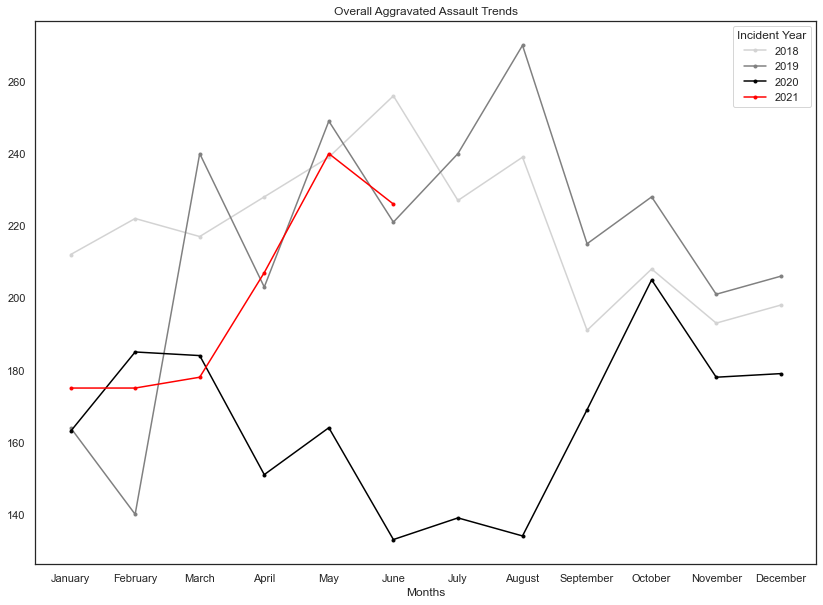

In [415]:
aggassault = violentincidents[violentincidents['UCR_part_1'] == 'aggravated assault']
aggassault2 = pd.pivot_table(aggassault, index = 'Months', columns = 'Incident Year', values = 'Incident ID', aggfunc = 'size')
aggassault2 = aggassault2.reindex(index = ['January', 'February', 'March', 'April', 'May', 
                                 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
aggassaultpl = aggassault2.plot(kind = 'line', figsize = (14,10),color = ['lightgray', 'gray', 'black', 'red'], 
                            marker = '.',rot = 0)

aggassaultpl.set_xticks(np.arange(0,12))
aggassaultpl.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 
                    'July', 'August', 'September', 'October','November', 'December'])
aggassaultpl.set_title('Overall Aggravated Assault Trends');

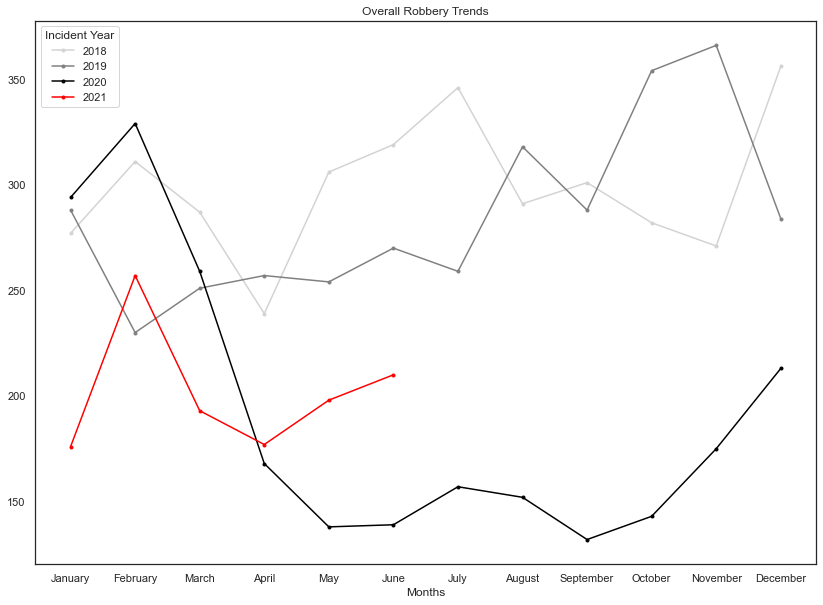

In [416]:
robbery = violentincidents[violentincidents['UCR_part_1'] == 'robbery']
robbery2 = pd.pivot_table(robbery, index = 'Months', columns = 'Incident Year', values = 'Incident ID', aggfunc = 'size')
robbery2 = robbery2.reindex(index = ['January', 'February', 'March', 'April', 'May', 
                                 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
robberypl = robbery2.plot(kind = 'line', figsize = (14,10),color = ['lightgray', 'gray', 'black', 'red'], 
                            marker = '.',rot = 0)

robberypl.set_xticks(np.arange(0,12))
robberypl.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 
                    'July', 'August', 'September', 'October','November', 'December'])
robberypl.set_title('Overall Robbery Trends');

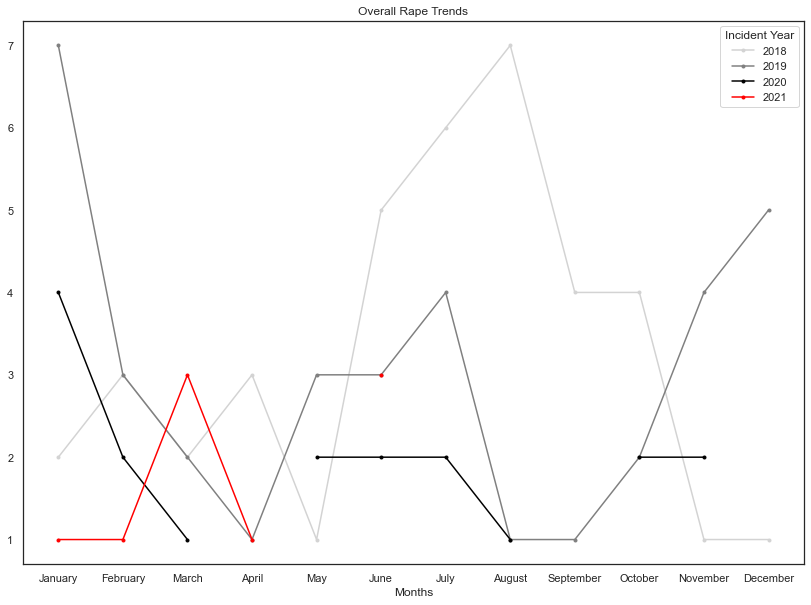

In [417]:
rape = violentincidents[violentincidents['UCR_part_1'] == 'rape']
rape2 = pd.pivot_table(rape, index = 'Months', columns = 'Incident Year', values = 'Incident ID', aggfunc = 'size')
rape2 = rape2.reindex(index = ['January', 'February', 'March', 'April', 'May', 
                                 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
rapepl = rape2.plot(kind = 'line', figsize = (14,10),color = ['lightgray', 'gray', 'black', 'red'], 
                            marker = '.',rot = 0)

rapepl.set_xticks(np.arange(0,12))
rapepl.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 
                    'July', 'August', 'September', 'October','November', 'December'])
rapepl.set_title('Overall Rape Trends');

In [488]:
propertyincidents['UCR_part_1'].value_counts()

larceny theft          130264
burglary                24378
motor vehicle theft     20158
arson                    1167
Name: UCR_part_1, dtype: int64

In [418]:
# one year pre-pandemic and one during/post
prepostviolent2 = pd.pivot_table(violentincidents, index = ['UCR_part_1', 'Months'], columns = 'Incident Year', values = 'Incident ID', aggfunc = 'size')
prepostviolent2 = prepostviolent2.rename_axis(['UCR_part_1', 'Months']).reset_index()
prepostviolent2

Incident Year,UCR_part_1,Months,2018,2019,2020,2021
0,aggravated assault,April,228.0,203.0,151.0,207.0
1,aggravated assault,August,239.0,270.0,134.0,NaN
2,aggravated assault,December,198.0,206.0,179.0,NaN
3,aggravated assault,February,222.0,140.0,185.0,175.0
4,aggravated assault,January,212.0,164.0,163.0,175.0
5,aggravated assault,July,227.0,240.0,139.0,NaN
6,aggravated assault,June,256.0,221.0,133.0,226.0
7,aggravated assault,March,217.0,240.0,184.0,178.0
8,aggravated assault,May,239.0,249.0,164.0,240.0
9,aggravated assault,November,193.0,201.0,178.0,NaN


In [419]:
#pd.DataFrame(prepostviolent.groupby(['UCR_part_1', 'Incident Year','Months']).agg('size'))

# Property Incidents

In [420]:
## property crime visualization
## 189373 property incidents with Incident Category Variable

## 168289 with UCR incident hierarchy

propertyincidents = filter_inrows_by_values(incident_report, 'UCR_part_1', ['burglary ', 'arson', 'larceny theft',
                                                                         'motor vehicle theft'])


In [421]:
propertyincidents.shape

(175967, 39)

In [422]:
property_incidents = pd.pivot_table(propertyincidents, index = 'Months', columns = 'Incident Year', values = 'UCR_part_1', aggfunc = 'size')
total_propertyincidents = property_incidents.reindex(index = ['January', 'February', 'March', 'April', 'May', 
                                 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
total_propertyincidents

Incident Year,2018,2019,2020,2021
Months,,,,
January,5368.0,4429.0,5061.0,3108.0
February,4295.0,4109.0,4281.0,3255.0
March,4568.0,4317.0,3347.0,3331.0
April,4615.0,4207.0,2895.0,3423.0
May,4831.0,4568.0,2862.0,4395.0
June,4843.0,4661.0,2534.0,4263.0
July,5610.0,5292.0,2824.0,NaN
August,5549.0,5485.0,2760.0,NaN
September,4964.0,5125.0,2286.0,NaN


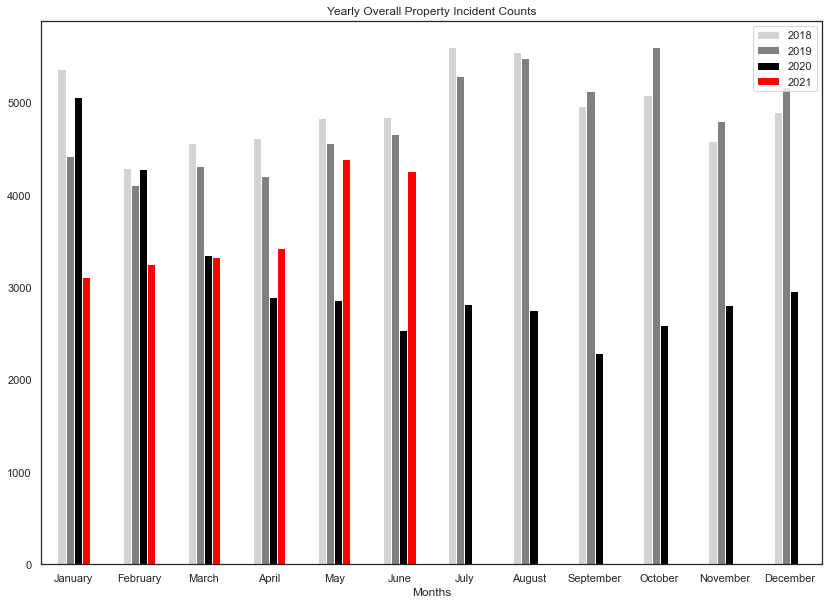

In [423]:
total_propertyincidents.plot(kind = 'bar', figsize = (14,10),color = ['lightgray', 'gray', 'black', 'red'], rot = 0)
plt.title('Yearly Overall Property Incident Counts')
plt.legend(loc = 'best');

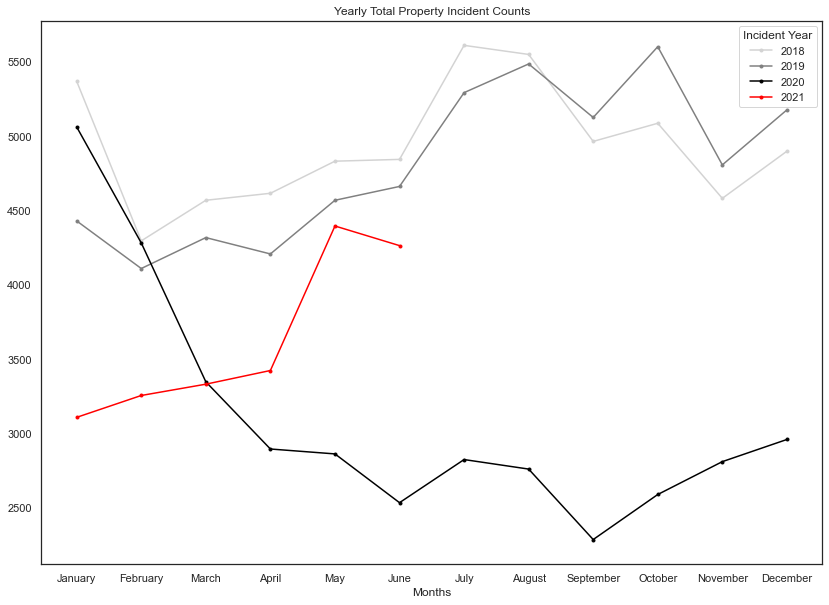

In [424]:
propertyline = total_propertyincidents.plot(kind = 'line', figsize = (14,10),color = ['lightgray', 'gray', 'black', 'red'], 
                            marker = '.',rot = 0)
propertyline.set_xticks(np.arange(0,12))
propertyline.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 
                    'July', 'August', 'September', 'October','November', 'December'])
propertyline.set_title('Yearly Total Property Incident Counts');

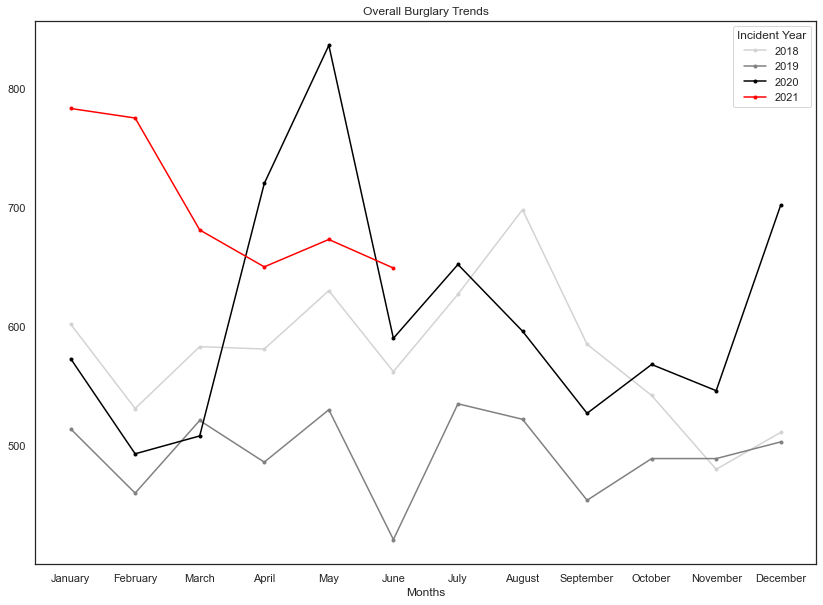

In [425]:
burglary = propertyincidents[propertyincidents['UCR_part_1'] == 'burglary ']
burglary2 = pd.pivot_table(burglary, index = 'Months', columns = 'Incident Year', values = 'Incident ID', aggfunc = 'size')
burglary2 = burglary2.reindex(index = ['January', 'February', 'March', 'April', 'May', 
                                 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
burglarypl = burglary2.plot(kind = 'line', figsize = (14,10),color = ['lightgray', 'gray', 'black', 'red'], 
                            marker = '.',rot = 0)

burglarypl.set_xticks(np.arange(0,12))
burglarypl.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 
                    'July', 'August', 'September', 'October','November', 'December'])
burglarypl.set_title('Overall Burglary Trends');

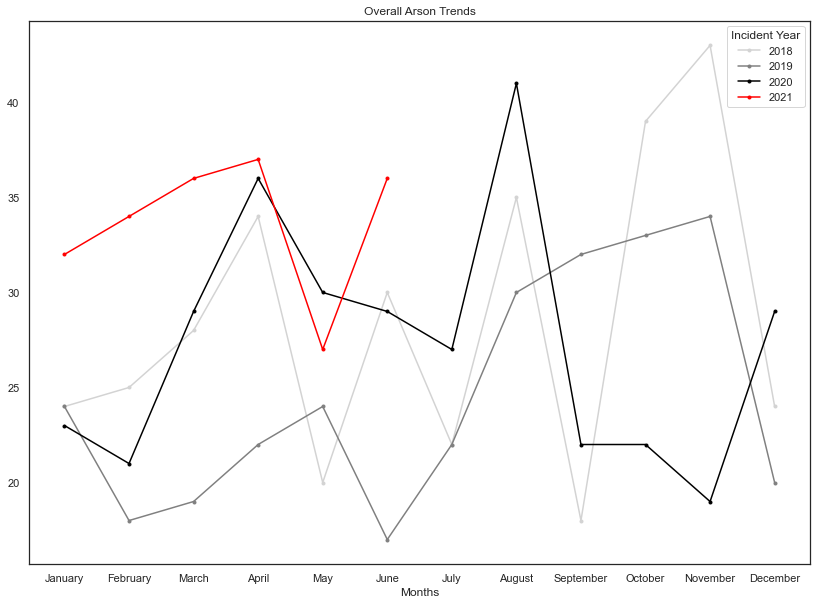

In [497]:
arson = propertyincidents[propertyincidents['UCR_part_1'] == 'arson']
arson2 = pd.pivot_table(arson, index = 'Months', columns = 'Incident Year', values = 'Incident ID', aggfunc = 'size')
arsonn2 = arson2.reindex(index = ['January', 'February', 'March', 'April', 'May', 
                                 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
arsonpl = arsonn2.plot(kind = 'line', figsize = (14,10),color = ['lightgray', 'gray', 'black', 'red'], 
                            marker = '.',rot = 0)
arsonpl.set_xticks(np.arange(0,12))
arsonpl.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 
                    'July', 'August', 'September', 'October','November', 'December'])

arsonpl.set_title('Overall Arson Trends');

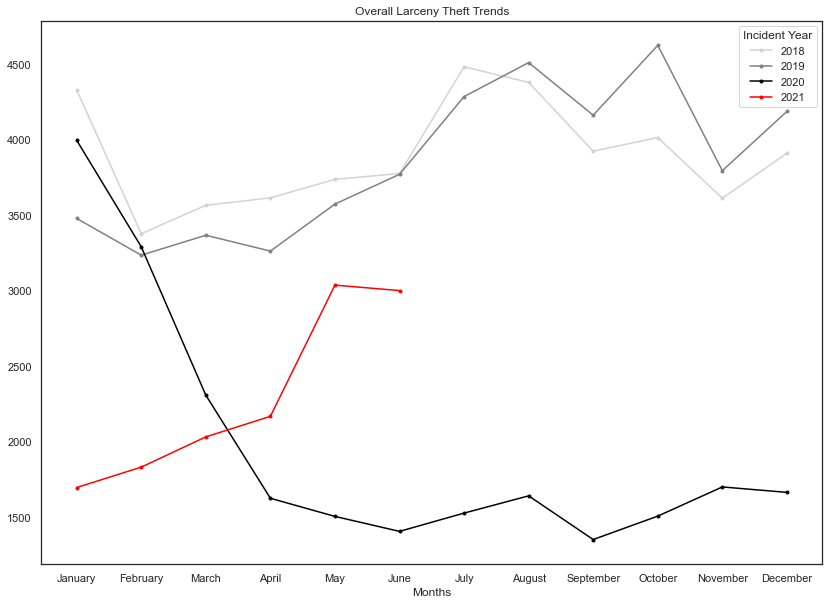

In [427]:
larcenytheft = propertyincidents[propertyincidents['UCR_part_1'] == 'larceny theft']
larcenytheft2 = pd.pivot_table(larcenytheft, index = 'Months', columns = 'Incident Year', values = 'Incident ID', aggfunc = 'size')
larcenytheft2 = larcenytheft2.reindex(index = ['January', 'February', 'March', 'April', 'May', 
                                 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
larcenytheftpl = larcenytheft2.plot(kind = 'line', figsize = (14,10),color = ['lightgray', 'gray', 'black', 'red'], 
                            marker = '.',rot = 0)

larcenytheftpl.set_xticks(np.arange(0,12))
larcenytheftpl.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 
                    'July', 'August', 'September', 'October','November', 'December'])
larcenytheftpl.set_title('Overall Larceny Theft Trends');

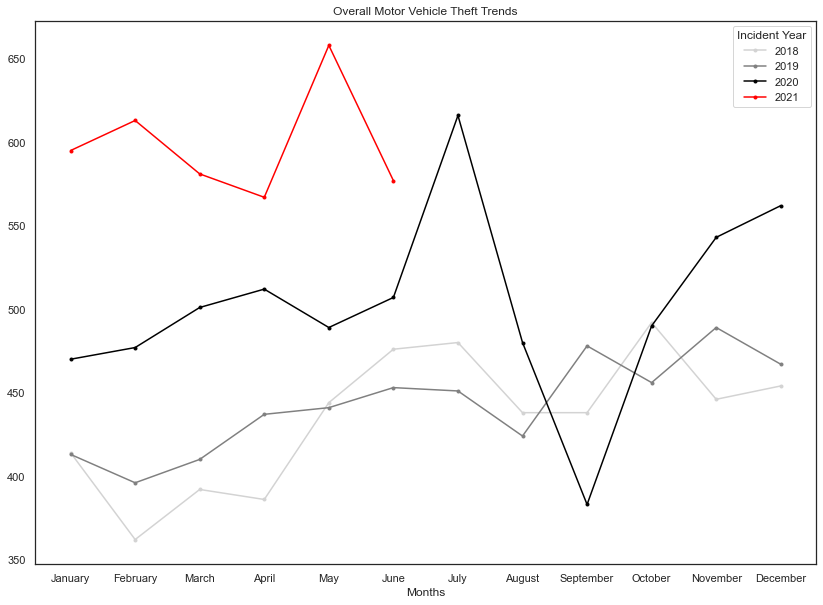

In [428]:
mtv = propertyincidents[propertyincidents['UCR_part_1'] == 'motor vehicle theft']
mtv2 = pd.pivot_table(mtv, index = 'Months', columns = 'Incident Year', values = 'Incident ID', aggfunc = 'size')
mtv2 = mtv2.reindex(index = ['January', 'February', 'March', 'April', 'May', 
                                 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
mtvpl = mtv2.plot(kind = 'line', figsize = (14,10),color = ['lightgray', 'gray', 'black', 'red'], 
                            marker = '.',rot = 0)

mtvpl.set_xticks(np.arange(0,12))
mtvpl.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 
                    'July', 'August', 'September', 'October','November', 'December'])
mtvpl.set_title('Overall Motor Vehicle Theft Trends');

In [429]:
pandemic_begins = incident_report[incident_report['Incident Date'] == '2020-03-17']

In [430]:
print(incident_report['Incident Date'].max())
print(incident_report['Incident Date'].min())

2021-06-30 00:00:00
2018-01-01 00:00:00


# Mapping

In [431]:
## reading in geometric map

sfmap = gpd.read_file('Analysis Neighborhoods.geojson')

<AxesSubplot:>

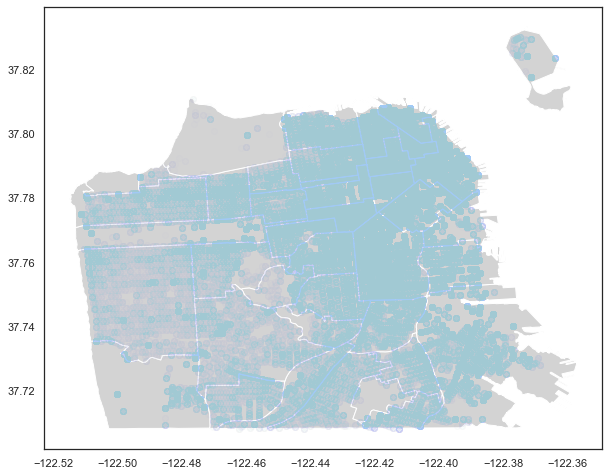

In [479]:
# SNS Style makes it easier to see exact locations

sns.set(style='white', palette='pastel', color_codes=True) 
sns.mpl.rc('figure', figsize=(10,10))

fig, ax = plt.subplots()
sfmap.plot(color = 'lightgrey', ax = ax)
total_incidents1.plot(ax = ax, alpha = .01)

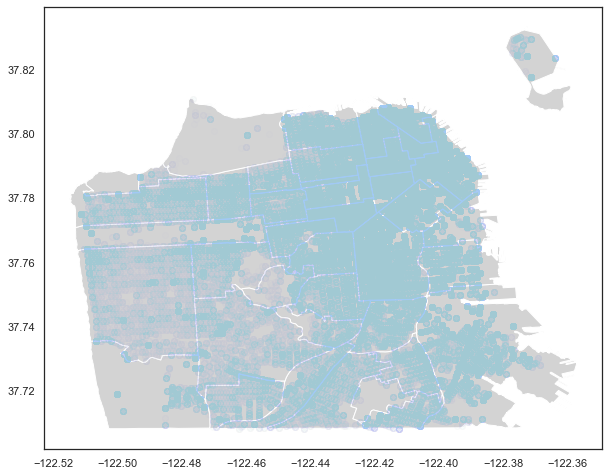

In [480]:
# matplotlib version uhhhh idk what happened//

fig, ax = plt.subplots(figsize = (10,10))
sfmap.plot(ax=ax, color='lightgrey')
other = total_incidents1.plot(ax=ax, alpha = .01)

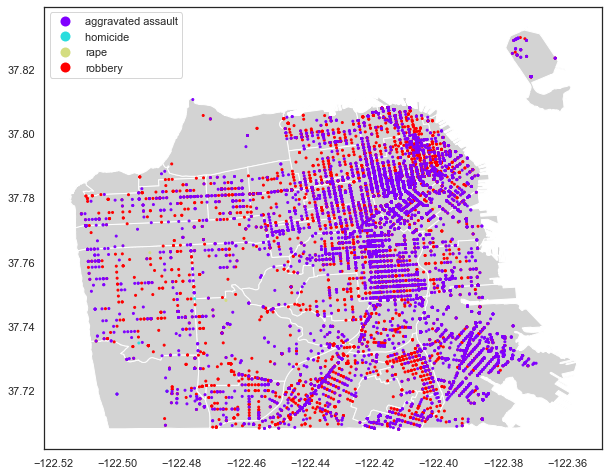

In [433]:
fig, ax = plt.subplots(figsize = (10,10))
sfmap.plot(color = 'lightgrey', ax = ax)
violentmap = violentincidents.plot(column = 'UCR_part_1', ax=ax,cmap = 'rainbow',
            legend = True, 
            markersize = 4)


<AxesSubplot:>

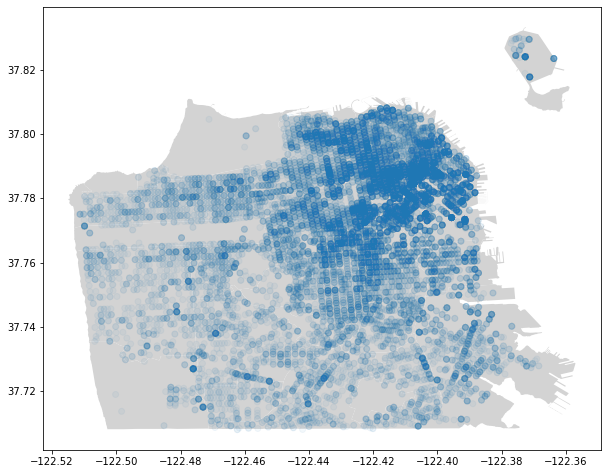

In [339]:
fig, ax = plt.subplots(figsize = (10,10))
sfmap.plot(color = 'lightgrey', ax = ax)
burglary.plot(column = 'UCR_part_1', ax=ax, alpha = .05)

In [202]:
sfmap.head()

,nhood,geometry,Coordinates
0,Bayview Hunters Point,"MULTIPOLYGON (((-122.38158 37.75307, -122.3815...","AxesSubplot(0.194853,0.125;0.635294x0.755)"
1,Bernal Heights,"MULTIPOLYGON (((-122.40361 37.74934, -122.4037...","AxesSubplot(0.194853,0.125;0.635294x0.755)"
2,Castro/Upper Market,"MULTIPOLYGON (((-122.42656 37.76948, -122.4269...","AxesSubplot(0.194853,0.125;0.635294x0.755)"
3,Chinatown,"MULTIPOLYGON (((-122.40623 37.79756, -122.4055...","AxesSubplot(0.194853,0.125;0.635294x0.755)"
4,Excelsior,"MULTIPOLYGON (((-122.42398 37.73155, -122.4239...","AxesSubplot(0.194853,0.125;0.635294x0.755)"


In [203]:
SF_shape.head()

,the_geom,NHOOD
0,MULTIPOLYGON (((-122.38157774241415 37.7530704...,Bayview Hunters Point
1,MULTIPOLYGON (((-122.40361299982803 37.7493370...,Bernal Heights
2,MULTIPOLYGON (((-122.42655500055683 37.7694849...,Castro/Upper Market
3,MULTIPOLYGON (((-122.4062259995664 37.79755900...,Chinatown
4,MULTIPOLYGON (((-122.42398200023331 37.7315519...,Excelsior
